## Importando bibliotecas necessárias

- *Hydrograph-py* para separar o fluxo de base a partir da série temporal de vazão

In [1]:
import pandas as pd
import geopandas as gpd
from Hydrograph.hydrograph import sepBaseflow
import matplotlib.pyplot as plt
import datetime as dt
from glob import glob

In [2]:
# Configurações do pandas
pd.options.mode.chained_assignment = None    # default='warn'  --> opção None

## Lendo os arquivos (.csv) de vazão e os limites da bacia em .geojson

In [18]:
#Diretório para leitura de arquivos e salvamento de resultados

# bacia = 'atibaia_cabeceira'
# bacia = 'camanducaia'
# bacia = 'capivari'
# bacia = 'corumbatai'
bacia = 'jundiai'


path = 'D:/projetos_qswatmod/' + f'{bacia}' + '/outputs/'
results_path = 'D:/projetos_qswatmod/' + f'{bacia}' + '/esc_superficial/'

In [19]:
#Dados de vazão da bacia hidrográfica selecionada
df = pd.read_csv(path + 'vazao.csv')

#Camada vetorial dos limites da bacia hidrográfica selecionada
boundaries = gpd.read_file(path + 'boundary.geojson')

In [20]:
#Visualizando a série temporal de vazão
df

,Date,Qobs
0,1/1/1997,1.098
1,1/2/1997,1.078
2,1/3/1997,1.039
3,1/4/1997,1.078
4,1/5/1997,1.078
...,...,...
2186,12/27/2002,1.078
2187,12/28/2002,1.058
2188,12/29/2002,1.058
2189,12/30/2002,1.117


## Dados da bacia

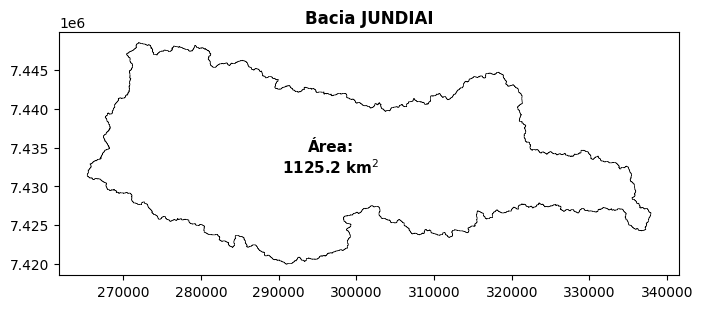

In [21]:
#Calculando a área da bacia em km^2
boundaries['area_km2'] = boundaries['geometry'].area / 10**6
area_bacia_km2 = boundaries.loc[0, 'area_km2']

#Calculando as coordenadas do centroide do polígono
boundaries['x'] = boundaries['geometry'].centroid.x
boundaries['y'] = boundaries['geometry'].centroid.y
x_coord = boundaries.loc[0, 'x']
y_coord = boundaries.loc[0, 'y']

#Plotando os limites da bacia hidrográfica
fig, ax1 = plt.subplots(figsize=(8, 8))

boundaries.boundary.plot(ax=ax1, color='k', lw=0.5, ls='-')

ax1.set_title(f'Bacia {bacia.upper()}', fontsize=12, color='k', weight='bold')
ax1.text(x_coord, y_coord, f'Área:\n{area_bacia_km2:.1f} km$^{2}$', va='center', ha='center', color='k', fontsize=11, fontweight='bold', bbox=dict(facecolor='w', alpha=0.6, edgecolor='w', ls='-'))    # transform=ax1.transAxes


plt.show()

## Análise dos dados

In [22]:
#Verificando o tipo das colunas
df.dtypes

Date     object
Qobs    float64
dtype: object

In [23]:
#Renomeando as colunas conforme instruções da documentação da biblioteca Hydrograph-py
df.rename(columns={'Date': 'Date',
                   'Qobs': 'Total runoff [m^3 s^-1]'}, inplace=True)

df.head()

,Date,Total runoff [m^3 s^-1]
0,1/1/1997,1.098
1,1/2/1997,1.078
2,1/3/1997,1.039
3,1/4/1997,1.078
4,1/5/1997,1.078


In [24]:
#Convertendo a coluna "Date" para o tipo datetime64
df['Date'] = pd.to_datetime(df['Date'])

In [25]:
#Conferindo o tipo das colunas
df.dtypes

Date                       datetime64[ns]
Total runoff [m^3 s^-1]           float64
dtype: object

In [ ]:
#Definindo a coluna "Date" como um DatetimeIndex do pandas
df.set_index('Date', inplace=True)

# df.head()

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2191 entries, 1997-01-01 to 2002-12-31
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Total runoff [m^3 s^-1]  2191 non-null   float64
dtypes: float64(1)
memory usage: 34.2 KB


In [57]:
#Selecionar um período caso necessário
# df = df.loc['1997-01-01': '2002-12-31']

In [35]:
#Conferindo o dataframe resultante
df

,Total runoff [m^3 s^-1]
Date,
1997-01-01,1.098
1997-01-02,1.078
1997-01-03,1.039
1997-01-04,1.078
1997-01-05,1.078
...,...
2002-12-27,1.078
2002-12-28,1.058
2002-12-29,1.058


In [36]:
#Verifincando se há falhas na série de vazão
falhas = df['Total runoff [m^3 s^-1]'].isna().sum()
print(f'Falhas: {falhas}')

Falhas: 0


In [37]:
#Obtendo o ano inicial, final e período de dados
ano_min = df.index.min().year
ano_max = df.index.max().year
periodo = (ano_max - ano_min) + 1

print(f'De {ano_min} a {ano_max} | {periodo} ano(s)')

De 1997 a 2002 | 6 ano(s)


In [ ]:
"""
Os valores do parâmetro k para cada sub-bacia PCJ foram ajustados individualmente
utilizando a metodologia apresentado no cap 1.
"""

#Ajustar os valores de k no Colab, antes de rodar aqui


if bacia == 'atibaia_cabeceira':
    k = 0.00002
    Area = area_bacia_km2
    print(f'Bacia: {bacia.upper()}\nÁrea (km^2): {round(Area, 2)}\nk: {k}')
elif bacia == 'camanducaia':
    k = 0.000025
    Area = area_bacia_km2
    print(f'Bacia: {bacia.upper()}\nÁrea (km^2): {round(Area, 2)}\nk: {k}')
elif bacia == 'capivari':
    k = 0.000064
    Area = area_bacia_km2
    print(f'Bacia: {bacia.upper()}\nÁrea (km^2): {round(Area, 2)}\nk: {k}')
elif bacia == 'corumbatai':
    k = 0.000025
    Area = area_bacia_km2
    print(f'Bacia: {bacia.upper()}\nÁrea (km^2): {round(Area, 2)}\nk: {k}')
else:
    k = 0.000004
    Area = area_bacia_km2
    print(f'Bacia: {bacia.upper()}\nÁrea (km^2): {round(Area, 2)}\nk: {k}')

Bacia: JUNDIAI
Área (km^2): 1125.24
k: 4e-06


## Executando a função *sepBaseflow*

In [39]:
df2 = sepBaseflow(df, 60, Area, k, dt_max=24, tp_min=6)

Processing using a 60-minute interval...
1997-01-01 00:00:00
1997-01-01 01:00:00
1997-01-01 02:00:00
1997-01-01 03:00:00
1997-01-01 04:00:00
1997-01-01 05:00:00
1997-01-01 06:00:00
1997-01-01 07:00:00
1997-01-01 08:00:00
1997-01-01 09:00:00
1997-01-01 10:00:00
1997-01-01 11:00:00
1997-01-01 12:00:00
1997-01-01 13:00:00
1997-01-01 14:00:00
1997-01-01 15:00:00
1997-01-01 16:00:00
1997-01-01 17:00:00
1997-01-01 18:00:00
1997-01-01 19:00:00
1997-01-01 20:00:00
1997-01-01 21:00:00
1997-01-01 22:00:00
1997-01-01 23:00:00
1997-01-02 00:00:00
1997-01-02 01:00:00
1997-01-02 02:00:00
1997-01-02 03:00:00
1997-01-02 04:00:00
1997-01-02 05:00:00
1997-01-02 06:00:00
1997-01-02 07:00:00
1997-01-02 08:00:00
1997-01-02 09:00:00
1997-01-02 10:00:00
1997-01-02 11:00:00
1997-01-02 12:00:00
1997-01-02 13:00:00
1997-01-02 14:00:00
1997-01-02 15:00:00
1997-01-02 16:00:00
1997-01-02 17:00:00
1997-01-02 18:00:00
1997-01-02 19:00:00
1997-01-02 20:00:00
1997-01-02 21:00:00
1997-01-02 22:00:00
1997-01-02 23:00:00

c:\Users\Wander\AppData\Local\Programs\Python\Python312\Lib\site-packages\Hydrograph\hydrograph.py:57: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dr = pd.date_range(minDate, maxDate, freq='60T')  #-60-minute interval


1997-02-12 19:00:00
1997-02-12 20:00:00
1997-02-12 21:00:00
1997-02-12 22:00:00
1997-02-12 23:00:00
1997-02-13 00:00:00
1997-02-13 01:00:00
1997-02-13 02:00:00
1997-02-13 03:00:00
1997-02-13 04:00:00
1997-02-13 05:00:00
1997-02-13 06:00:00
1997-02-13 07:00:00
1997-02-13 08:00:00
1997-02-13 09:00:00
1997-02-13 10:00:00
1997-02-13 11:00:00
1997-02-13 12:00:00
1997-02-13 13:00:00
1997-02-13 14:00:00
1997-02-13 15:00:00
1997-02-13 16:00:00
1997-02-13 17:00:00
1997-02-13 18:00:00
1997-02-13 19:00:00
1997-02-13 20:00:00
1997-02-13 21:00:00
1997-02-13 22:00:00
1997-02-13 23:00:00
1997-02-14 00:00:00
1997-02-14 01:00:00
1997-02-14 02:00:00
1997-02-14 03:00:00
1997-02-14 04:00:00
1997-02-14 05:00:00
1997-02-14 06:00:00
1997-02-14 07:00:00
1997-02-14 08:00:00
1997-02-14 09:00:00
1997-02-14 10:00:00
1997-02-14 11:00:00
1997-02-14 12:00:00
1997-02-14 13:00:00
1997-02-14 14:00:00
1997-02-14 15:00:00
1997-02-14 16:00:00
1997-02-14 17:00:00
1997-02-14 18:00:00
1997-02-14 19:00:00
1997-02-14 20:00:00


c:\Users\Wander\AppData\Local\Programs\Python\Python312\Lib\site-packages\Hydrograph\hydrograph.py:152: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NaT' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_final.loc[df_final['Peak nr.'] ==i, 'Date max. flow'] = mdate


Processing completed successfully.


In [40]:
#Cópia do dataframe para análises posteriores
df3 = df2.copy(deep=True)

In [41]:
#Seleção das colunas (variáveis) desejadas e renoameando-as para termos mais simples

df3['Vazao_calc_cms'] = df3['Baseflow [m^3 s^-1]'] + df3['Peakflow [m^3 s^-1]']

df3 = df3.loc[:, ['Vazao_calc_cms', 'Baseflow [m^3 s^-1]', 'Peakflow [m^3 s^-1]']]


df3.rename(columns={'Baseflow [m^3 s^-1]': 'Fluxo_base_cms',
                    'Peakflow [m^3 s^-1]': 'Esc_superficial_cms'}, inplace=True)

df3

,Vazao_calc_cms,Fluxo_base_cms,Esc_superficial_cms
Date,,,
1997-01-01 00:00:00,1.098000,1.098000,0.000000
1997-01-01 01:00:00,1.097167,1.097167,0.000000
1997-01-01 02:00:00,1.096333,1.096333,0.000000
1997-01-01 03:00:00,1.095500,1.095500,0.000000
1997-01-01 04:00:00,1.094667,1.094667,0.000000
...,...,...,...
2002-12-30 20:00:00,1.233667,1.207019,0.026647
2002-12-30 21:00:00,1.239500,1.211520,0.027980
2002-12-30 22:00:00,1.245333,1.216021,0.029312


In [42]:
#Reamostragem para escala diária
df3 = df3.resample('D').agg({'Vazao_calc_cms': 'mean',
                             'Fluxo_base_cms': 'mean',
                             'Esc_superficial_cms': 'mean'})

df3

,Vazao_calc_cms,Fluxo_base_cms,Esc_superficial_cms
Date,,,
1997-01-01,1.088417,1.088417,0.000000
1997-01-02,1.059313,1.059313,0.000000
1997-01-03,1.057687,1.057687,0.000000
1997-01-04,1.078000,1.078000,0.000000
1997-01-05,1.242833,1.129761,0.113072
...,...,...,...
2002-12-27,1.068417,1.068417,0.000000
2002-12-28,1.058000,1.058000,0.000000
2002-12-29,1.086271,1.086271,0.000000


## Visualizando

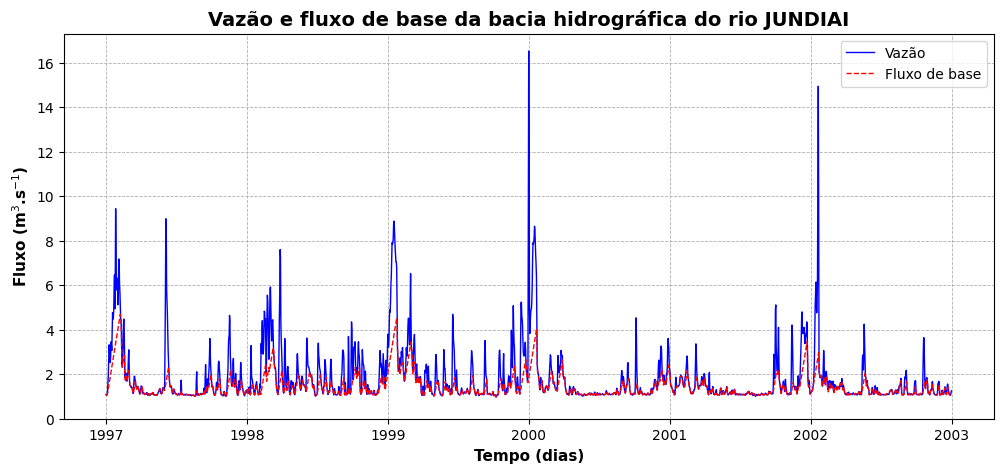

In [43]:
#Configurando a figura
plt.figure(figsize=(12, 5))

#Plotando vazão e fluxo de base
plt.plot(df3.index, df3['Vazao_calc_cms'], color='blue', lw=1.0, ls='-', label='Vazão')
plt.plot(df3.index, df3['Fluxo_base_cms'], color='red', lw=1.0, ls='--', label='Fluxo de base')

#Demais elementos do gráfico
plt.title(f'Vazão e fluxo de base da bacia hidrográfica do rio {bacia.upper()}', fontsize=14, color='k', weight='bold')
plt.ylabel('Fluxo (m$^{3}$.s$^{-1}$)', fontsize=11, color='k', weight='bold')
plt.xlabel('Tempo (dias)', fontsize=11, color='k', weight='bold')
plt.ylim(0, None)
plt.legend()
plt.grid(True, lw=0.6, ls='--')


# plt.xlim(dt.datetime(2005, 1, 1), dt.datetime(2005, 12, 31))    # Para filtrar um determinado período no gráfico

plt.show()

## Exportando

In [44]:
df_export = df3.copy(deep=True)
df_export.drop('Esc_superficial_cms', axis=1, inplace=True)
df_export.rename(columns={'Vazao_calc_cms': 'streamflow',
                          'Fluxo_base_cms': 'baseflow'}, inplace=True)
df_export.reset_index('Date', inplace=True)

df_export

,Date,streamflow,baseflow
0,1997-01-01,1.088417,1.088417
1,1997-01-02,1.059313,1.059313
2,1997-01-03,1.057687,1.057687
3,1997-01-04,1.078000,1.078000
4,1997-01-05,1.242833,1.129761
...,...,...,...
2186,2002-12-27,1.068417,1.068417
2187,2002-12-28,1.058000,1.058000
2188,2002-12-29,1.086271,1.086271
2189,2002-12-30,1.184083,1.168761


In [46]:
df_export = df_export.assign(Bacia=bacia.capitalize())
df_export = df_export.assign(Area=area_bacia_km2)

df_export

,Date,streamflow,baseflow,Bacia,Area
0,1997-01-01,1.088417,1.088417,Jundiai,1125.2412
1,1997-01-02,1.059313,1.059313,Jundiai,1125.2412
2,1997-01-03,1.057687,1.057687,Jundiai,1125.2412
3,1997-01-04,1.078000,1.078000,Jundiai,1125.2412
4,1997-01-05,1.242833,1.129761,Jundiai,1125.2412
...,...,...,...,...,...
2186,2002-12-27,1.068417,1.068417,Jundiai,1125.2412
2187,2002-12-28,1.058000,1.058000,Jundiai,1125.2412
2188,2002-12-29,1.086271,1.086271,Jundiai,1125.2412
2189,2002-12-30,1.184083,1.168761,Jundiai,1125.2412


In [47]:
df_export.to_csv('D:/projetos_qswatmod/baseflow_csv_file/' + f'bf_{bacia.lower()}' + '.csv', index=False, float_format='%.2f')

## Processamento para gerar a série de escoamento superficial

In [48]:
df3.head()

,Vazao_calc_cms,Fluxo_base_cms,Esc_superficial_cms
Date,,,
1997-01-01,1.088417,1.088417,0.000000
1997-01-02,1.059313,1.059313,0.000000
1997-01-03,1.057687,1.057687,0.000000
1997-01-04,1.078000,1.078000,0.000000
1997-01-05,1.242833,1.129761,0.113072


In [49]:
esc_sup = df3.copy(deep=True)
esc_sup = esc_sup.resample('MS').mean()
cols = ['Esc_superficial_cms']
esc_sup = esc_sup[cols]
esc_sup.reset_index('Date', inplace=True)
esc_sup.rename(columns={'Date': 'Data',
                        'Esc_superficial_cms': 'Esc. superficial (m^3/s)'}, inplace=True)

esc_sup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Data                      72 non-null     datetime64[ns]
 1   Esc. superficial (m^3/s)  72 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.3 KB


In [50]:
esc_sup

,Data,Esc. superficial (m^3/s)
0,1997-01-01,1.642238
1,1997-02-01,0.663192
2,1997-03-01,0.078872
3,1997-04-01,0.011433
4,1997-05-01,0.004561
...,...,...
67,2002-08-01,0.026915
68,2002-09-01,0.128794
69,2002-10-01,0.270478
70,2002-11-01,0.055608


In [51]:
area_bacia_m2 = area_bacia_km2 * 10 ** 6

print(f'Área da bacia (m^2): {round(area_bacia_m2, 1)}')

Área da bacia (m^2): 1125241200.0


In [52]:
#Conversão do escoamento superficial de m^3/s para mm/dia
area_bacia_m2 = area_bacia_km2 * 10 ** 6
esc_sup['Esc. superficial (mm/dia)'] = esc_sup.apply((lambda x: (x['Esc. superficial (m^3/s)'] / area_bacia_m2) * (1000 * 3600 * 24 * 30.42)), axis=1)  # conferir unidade dessa col

esc_sup

,Data,Esc. superficial (m^3/s),Esc. superficial (mm/dia)
0,1997-01-01,1.642238,3.835867
1,1997-02-01,0.663192,1.549054
2,1997-03-01,0.078872,0.184227
3,1997-04-01,0.011433,0.026705
4,1997-05-01,0.004561,0.010653
...,...,...,...
67,2002-08-01,0.026915,0.062868
68,2002-09-01,0.128794,0.300832
69,2002-10-01,0.270478,0.631771
70,2002-11-01,0.055608,0.129886


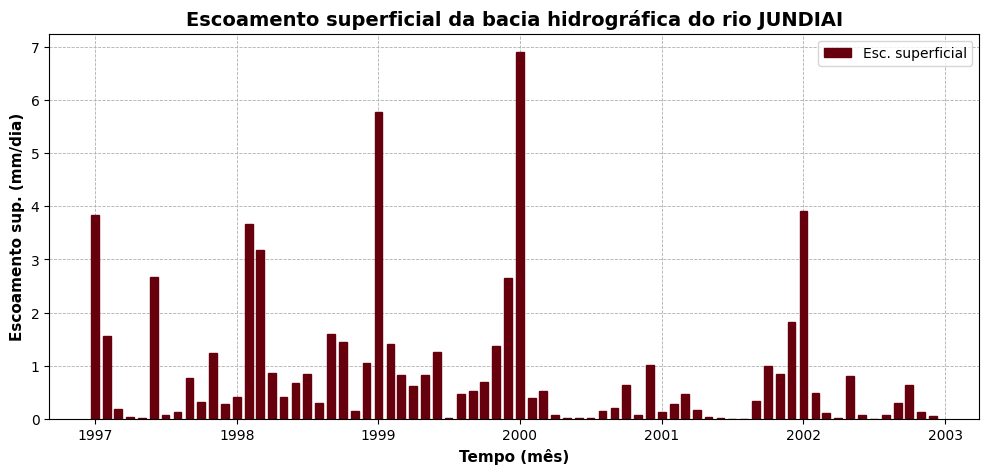

In [53]:
#Configurando a figura
plt.figure(figsize=(12, 5))

plt.bar(esc_sup['Data'], esc_sup['Esc. superficial (mm/dia)'], width=20, color='#67000D', edgecolor='#67000D', label='Esc. superficial', zorder=2)

#Demais elementos do gráfico
plt.title(f'Escoamento superficial da bacia hidrográfica do rio {bacia.upper()}', fontsize=14, color='k', weight='bold')
plt.ylabel('Escoamento sup. (mm/dia)', fontsize=11, color='k', weight='bold')
plt.xlabel('Tempo (mês)', fontsize=11, color='k', weight='bold')
plt.ylim(0, None)
plt.legend()
plt.grid(True, lw=0.6, ls='--')

#Visualizando
plt.show()